## Invivo Report

Building a classifier to predict binary values of molecules

In [1]:
# Read necessary libaries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import rdkit
from rdkit import Chem
from rdkit.Chem import Fragments, Descriptors

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, matthews_corrcoef
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l1

from xgboost import XGBClassifier

#### Read in data file given

In [2]:
df = pd.read_csv('data.csv')

#### Read in helper text files for creating features

In [3]:
f = open('fn_group.txt', 'r')
fng_list = f.read().split('\n')
f.close()

f = open('descriptors.txt', 'r')
desc_list = f.read().split('\n')
f.close()

f = open('chem_desc.txt', 'r')
chem_list = f.read().split('\n')
f.close()

#### Create new columns of data

In [4]:
#for each descriptor in descriptor.txt 
for descriptor in desc_list:
    string_search = "Descriptors."+ descriptor+"(Chem.MolFromSmiles(x))"
    df[descriptor] = df['smiles'].apply(lambda x: eval(string_search))
    print(f"{descriptor}:Descriptor added to Frame")
    
#for each functional group in fn_group.txt count how many   
for fn_group in fng_list:
    string_search = "Fragments."+fn_group+"(Chem.MolFromSmiles(x))"
    df[fn_group] = df['smiles'].apply(lambda x: eval(string_search))
    print(f"{fn_group}:Function group added to Frame")
    
#for each Chemical descriptor in chem_list.txt 
for chem in chem_list:
    string_search = "Chem."+ chem +"(Chem.MolFromSmiles(x))"
    df[chem] = df['smiles'].apply(lambda x: eval(string_search))
    print(f"{chem}:Chem_Descriptor added to Frame")

ExactMolWt:Descriptor added to Frame
HeavyAtomMolWt:Descriptor added to Frame
MolWt:Descriptor added to Frame
NumRadicalElectrons:Descriptor added to Frame
Chi0:Descriptor added to Frame
Chi1:Descriptor added to Frame
NHOHCount:Descriptor added to Frame
MolLogP:Descriptor added to Frame
MolMR:Descriptor added to Frame
HeavyAtomCount:Descriptor added to Frame
NOCount:Descriptor added to Frame
NumHAcceptors:Descriptor added to Frame
NumHDonors:Descriptor added to Frame
NumHeteroatoms:Descriptor added to Frame
NumRotatableBonds:Descriptor added to Frame
NumValenceElectrons:Descriptor added to Frame
RingCount:Descriptor added to Frame
fr_Al_OH:Function group added to Frame
fr_Al_OH_noTert:Function group added to Frame
fr_ArN:Function group added to Frame
fr_Ar_COO:Function group added to Frame
fr_Ar_N:Function group added to Frame
fr_Ar_NH:Function group added to Frame
fr_Ar_OH:Function group added to Frame
fr_COO:Function group added to Frame
fr_COO2:Function group added to Frame
fr_C_O:F

In [5]:
#Count the amount of chiral centres each molecule has
df['FindMolChiralCenters'] = df['FindMolChiralCenters'].apply(len)

### Data Cleaning/Prepping

In [6]:
#prep dataframe with target and drop null values
def clean_data(df, target):
    df_target = pd.concat([df[[target]] , df.iloc[:,13:]], axis=1)
    df_target.dropna(inplace = True)
    return df_target, target

#dataset is severely unbalanced, undersample as way to help train 
def undersample(df, target):
    nottrue_indices = df[df[target] == 0].index
    df_true = df[df[target]==1]
    size = df[df[target]==1].shape[0]
    random_indices = np.random.choice(nottrue_indices, size, replace=False)
    nottrue_sample = df.loc[random_indices]
    new_sample = nottrue_sample.append(df_true, ignore_index=True)
    return new_sample, target

# normalize data and split data
def split_normalize(df, target):
    df_y = df[[target]]
    df_x = df.drop([target], axis=1)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(df_x.values)
    df_x = scaler.transform(df_x.values)
    
    x, x_val, y, y_val = train_test_split(df_x, df_y, test_size=int(0.2*df_x.shape[0]), random_state=42)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=int(0.2*df_x.shape[0]), random_state=42)
    
    return x_train, y_train, x_val, y_val, x_test, y_test, scaler

# call functions and return necessary data ready for modelling
def get_data_under(df, target):
    df_clean, _ = clean_data(df, target)
    df_new_sample, _ = undersample(df_clean, target)
    x_train, y_train, x_val, y_val, x_test, y_test, scaler = split_normalize(df_new_sample, target)   
    return x_train, y_train, x_val, y_val, x_test, y_test, scaler


#If we don't want to undersample
def get_data_norm(df, target):
    df_clean, _ = clean_data(df, target)
    x_train, y_train, x_val, y_val, x_test, y_test, scaler = split_normalize(df_clean, target)   
    return x_train, y_train, x_val, y_val, x_test, y_test, scaler  

#### Define measures to gauge models

In [7]:
def measures(cm):
    recall = cm[0][0]/(cm[0][0]+cm[1][0])
    precision = cm[0][0]/(cm[0][0]+cm[0][1])
    f_measure = (2*recall*precision)/(recall+precision)
    return recall, precision, f_measure

### Define/Build Models

In [8]:

#Basic sklearn log model for baseline testing
def log_model(x_train, y_train, x_val, y_val, x_test, y_test):
    logisticRegr = LogisticRegression(solver='liblinear')
    logisticRegr.fit(x_train, y_train.values.ravel())
    
    predict_val = logisticRegr.predict(x_val)
    score_val = logisticRegr.score(x_val, y_val)
    cm_val = confusion_matrix(y_val, predict_val)
    
    predict_test = logisticRegr.predict(x_test)
    score_test = logisticRegr.score(x_test, y_test)
    cm_test = confusion_matrix(y_test, predict_test)
    return score_val, cm_val, score_test, cm_test


# DEFINE KERAS MODEL 
def build_model_nn(dim):
    keras.backend.clear_session()
    model = keras.Sequential([
        keras.layers.Dense(128, activation=tf.nn.relu, input_shape=[dim]),
        keras.layers.Dense(256, activation=tf.nn.relu, activity_regularizer=l1(0.01)),
        keras.layers.Dropout(0.5),
#         keras.layers.Dense(256, activation=tf.nn.relu),
#         keras.layers.Dropout(0.5),
#         keras.layers.Dense(128, activation=tf.nn.relu),
#         keras.layers.Dropout(0.5),
#         keras.layers.Dense(256, activation=tf.nn.relu),
#         keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dense(1, activation=tf.nn.sigmoid)
        ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy'])
    return model


# DEFINE XGBOOST CLASSIFIER
def build_model_xgb():
    model_xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
    return model_xgb

### Define Fit Functions for Models

In [9]:
def nn_model_fit(model_nn, x_train, y_train ,x_val, y_val):
    es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                                    patience=3,verbose=0, mode='auto')
    history = model_nn.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val),
                         callbacks = [es],  verbose=0, shuffle=False)                          
    return history, es

def xgb_model_fit(model_xgb, x_train, y_train, x_val, y_val):
    model_xgb.fit(x_train, y_train.values.ravel(), 
                early_stopping_rounds=10, 
                eval_metric=["error","logloss"], 
                eval_set=[(x_train, y_train.values.ravel()),
                          (x_val, y_val.values.ravel())], 
                verbose=False)
  # retrieve performance metrics
    results = model_xgb.evals_result()
    return results

### Define Functions for Predictions

In [10]:
#Based on validation choose which model to predict in certain cases
def choose_best(xgb_model, nn_model, x_val, y_val, target):
    #xbg prediction on validation set
    y_pred = xgb_model.predict(x_val)
    predictions_xgb = [round(value) for value in y_pred]
    #nn prediction on validation set
    predictions_nn = nn_model.predict_classes(x_val)
    
    #create dataframe with y_validation and both models predictions
    df_pred_val = y_val.copy()
    df_pred_val['pred_xgb'] = predictions_xgb;
    df_pred_val['pred_nn'] = predictions_nn;

    y_equal = df_pred_val[df_pred_val['pred_xgb']==df_pred_val['pred_nn']]
    y_nonequal = df_pred_val[df_pred_val['pred_xgb']!=df_pred_val['pred_nn']]
    
    model_acc = accuracy_score(y_equal[target], y_equal['pred_xgb'])
    print(f'pred_NN==XGB Accuracy: {model_acc:.3f}')
    y_xgb_0 = y_nonequal[y_nonequal['pred_xgb']==0]
    y_xgb_1 = y_nonequal[y_nonequal['pred_xgb']==1]
    
    xgb_0_acc = accuracy_score(y_xgb_0[target], y_xgb_0['pred_xgb'])
    xgb_1_acc = accuracy_score(y_xgb_1[target], y_xgb_1['pred_xgb'])
    print(f'XGB=0 != NN accuracy: {xgb_0_acc:.3f}')
    print(f'XGB=1 != NN accuracy: {xgb_1_acc:.3f}')
    
    return df_pred_val, xgb_0_acc, xgb_1_acc


#Return prediction based on best of both models as set by validation set
def combined_prediction(df_pred, xgb_0_acc, xgb_1_acc):
    #if both algos predict same value output value
    #if their prediction differs, output the one with higher validation accuracy on that value ie. 0/1
    if df_pred['pred_nn'] == df_pred['pred_xgb']:
        return df_pred['pred_nn']
    elif df_pred['pred_xgb']==0:
        if xgb_0_acc > 0.5:
            return df_pred['pred_xgb']
        else:
            return df_pred['pred_nn']
    else:
        if xgb_1_acc > 0.5:
            return df_pred['pred_xgb']
        else:
            return df_pred['pred_nn']

# Compare each of the model predictions
def compare_predictions(df):
    #print method for comparing models when training/validating
    list_predictions = ['pred_xgb','pred_nn','combined']
    print("Validation set Accuracy")
    for pred in list_predictions:
        accuracy = accuracy_score(df.iloc[:,0], df[pred])
        print(f"{pred}: {accuracy:.3f}") 

#Final prediction on Test Set
def final_prediction(xgb_model, nn_model, x_test, xgb_0_acc, xgb_1_acc):
    #get 1-D array of best prediction of both algorithms
    y_pred = xgb_model.predict(x_test)
    predictions_xgb = [round(value) for value in y_pred]
    #nn prediction on validation set
    predictions_nn = nn_model.predict_classes(x_test)
    
    #create dataframe with y_validation and both models predictions
    df_pred = pd.DataFrame()
    df_pred['pred_xgb'] = predictions_xgb;
    df_pred['pred_nn'] = predictions_nn;
    df = df_pred.apply(combined_prediction, xgb_0_acc=xgb_0_acc, xgb_1_acc=xgb_1_acc, axis =1)
    return df    

### Running the the models

W0813 11:43:34.316627 4669914432 deprecation.py:506] From /Users/tashlin/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor






Modeling: target1




W0813 11:43:34.502135 4669914432 deprecation.py:323] From /Users/tashlin/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


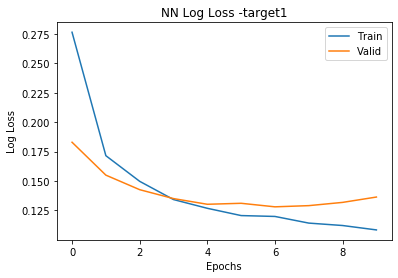

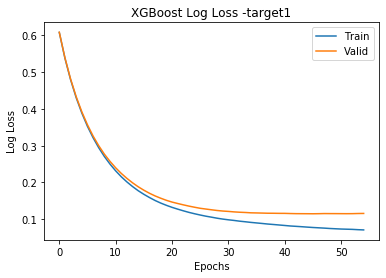

pred_NN==XGB Accuracy: 0.975
XGB=0 != NN accuracy: 0.500
XGB=1 != NN accuracy: 0.750
Validation set Accuracy
pred_xgb: 0.974
pred_nn: 0.972
combined: 0.974
pred_LogReg:0.966:Baseline




Modeling: target2




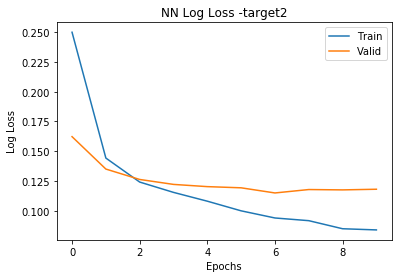

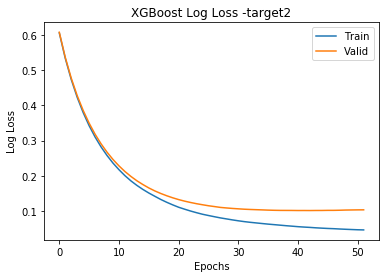

pred_NN==XGB Accuracy: 0.977
XGB=0 != NN accuracy: 1.000
XGB=1 != NN accuracy: 0.429
Validation set Accuracy
pred_xgb: 0.975
pred_nn: 0.973
combined: 0.975
pred_LogReg:0.970:Baseline




Modeling: target3




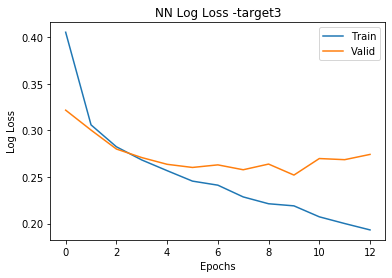

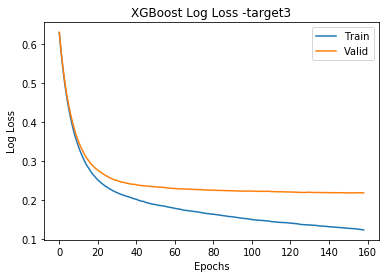

pred_NN==XGB Accuracy: 0.935
XGB=0 != NN accuracy: 0.615
XGB=1 != NN accuracy: 0.727
Validation set Accuracy
pred_xgb: 0.922
pred_nn: 0.908
combined: 0.922
pred_LogReg:0.898:Baseline




Modeling: target4




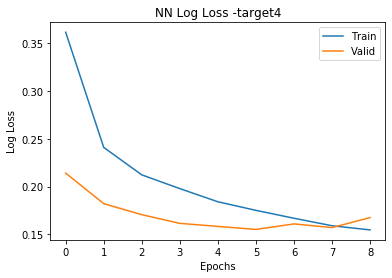

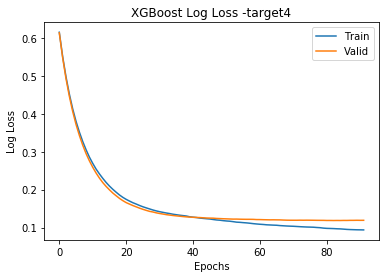

pred_NN==XGB Accuracy: 0.972
XGB=0 != NN accuracy: 0.833
XGB=1 != NN accuracy: 0.000
Validation set Accuracy
pred_xgb: 0.968
pred_nn: 0.956
combined: 0.970
pred_LogReg:0.960:Baseline




Modeling: target5




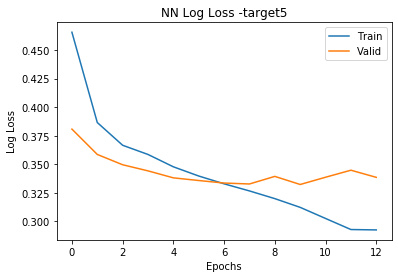

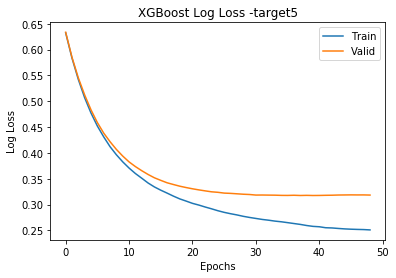

pred_NN==XGB Accuracy: 0.905
XGB=0 != NN accuracy: 0.607
XGB=1 != NN accuracy: 0.571
Validation set Accuracy
pred_xgb: 0.896
pred_nn: 0.891
combined: 0.896
pred_LogReg:0.879:Baseline




Modeling: target6




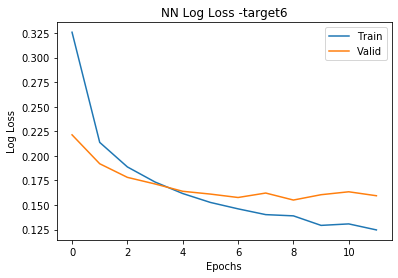

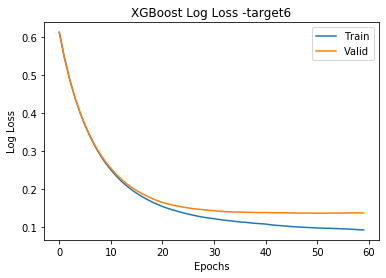

pred_NN==XGB Accuracy: 0.970
XGB=0 != NN accuracy: 0.429
XGB=1 != NN accuracy: 0.375
Validation set Accuracy
pred_xgb: 0.961
pred_nn: 0.964
combined: 0.964
pred_LogReg:0.956:Baseline




Modeling: target7




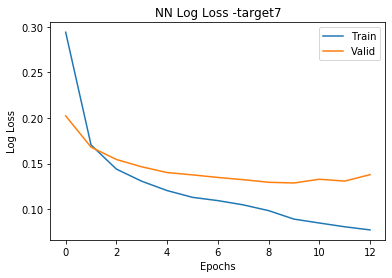

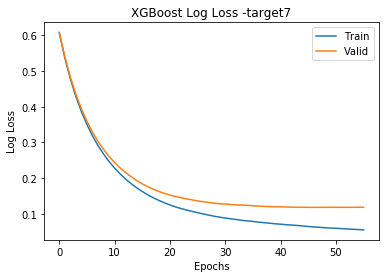

pred_NN==XGB Accuracy: 0.975
XGB=0 != NN accuracy: 0.409
XGB=1 != NN accuracy: 0.000
Validation set Accuracy
pred_xgb: 0.965
pred_nn: 0.969
combined: 0.969
pred_LogReg:0.966:Baseline




Modeling: target8




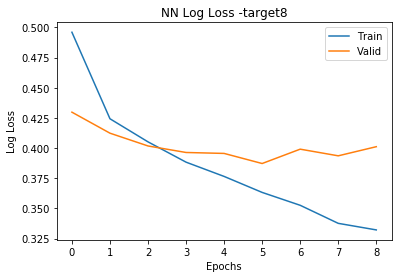

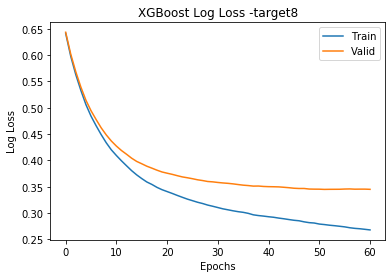

pred_NN==XGB Accuracy: 0.878
XGB=0 != NN accuracy: 0.464
XGB=1 != NN accuracy: 0.565
Validation set Accuracy
pred_xgb: 0.853
pred_nn: 0.853
combined: 0.856
pred_LogReg:0.826:Baseline




Modeling: target9




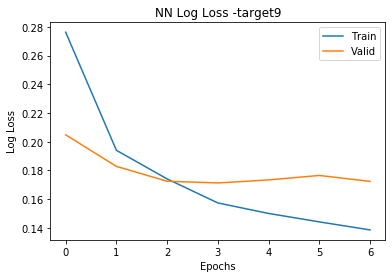

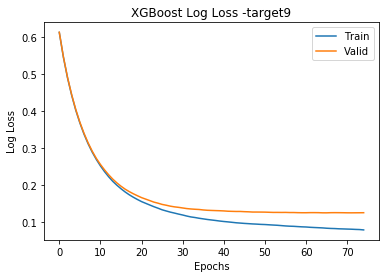

pred_NN==XGB Accuracy: 0.964
XGB=0 != NN accuracy: nan
XGB=1 != NN accuracy: 0.500
Validation set Accuracy
pred_xgb: 0.963
pred_nn: 0.963
combined: 0.963
pred_LogReg:0.963:Baseline




Modeling: target10




/Users/tashlin/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/tashlin/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/tashlin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


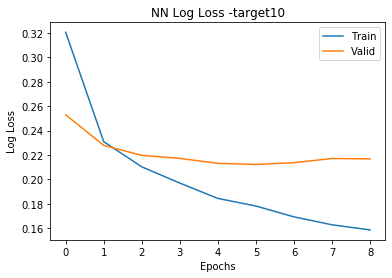

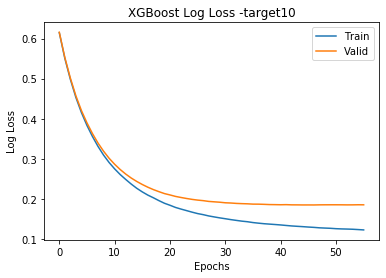

pred_NN==XGB Accuracy: 0.945
XGB=0 != NN accuracy: 0.667
XGB=1 != NN accuracy: 1.000
Validation set Accuracy
pred_xgb: 0.944
pred_nn: 0.939
combined: 0.944
pred_LogReg:0.942:Baseline




Modeling: target11




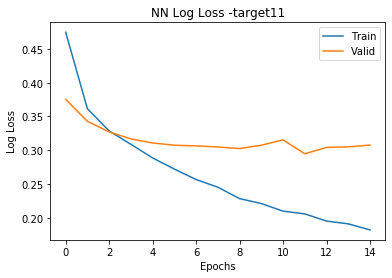

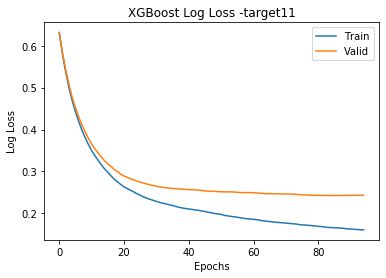

pred_NN==XGB Accuracy: 0.938
XGB=0 != NN accuracy: 0.514
XGB=1 != NN accuracy: 0.520
Validation set Accuracy
pred_xgb: 0.903
pred_nn: 0.900
combined: 0.903
pred_LogReg:0.854:Baseline




Modeling: target12




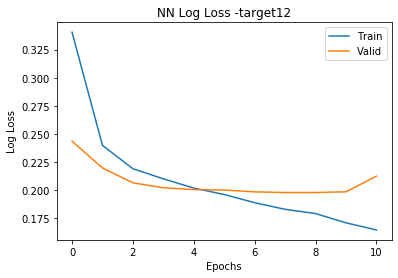

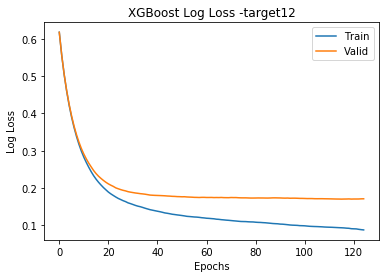

pred_NN==XGB Accuracy: 0.949
XGB=0 != NN accuracy: 0.333
XGB=1 != NN accuracy: 0.364
Validation set Accuracy
pred_xgb: 0.941
pred_nn: 0.945
combined: 0.945
pred_LogReg:0.942:Baseline


In [11]:
#initialize lists for saving history

#accuracy of each model and different stages, each element is one target
train_list = [] #[[xgb_accuracy_target_1, nn_accuracy_target_1], [xgb_accuracy_target_2, nn_accuracy_target_2]] 
val_list = [] #[[xgb_val_acc_target_1, nn_val_acc_target_1, logreg_val_acc, combined_val_acc], .... ]
test_list =[] #[[xgb_test_acc_target_1, nn_test_acc_target_1, logreg_test_acc, combined_test_acc], .... ]

# confusion matrices for TEST sets based on algorithm
nn_cm = []
xgb_cm = []
comb_cm = []
logreg_cm = []

# Mathews correlations coefficient for each target, based on algorithm
nn_mcc = []
xgb_mcc = []
comb_mcc = []

#run loop over all targets
for i in range(1,13):

    target = 'target'+ str(i)
    print("\n")
    print("\n")
    print(f"Modeling: {target}")
    print("\n")


    # x_train, y_train, x_val, y_val, x_test, y_test, scaler = get_data_under(df, target)
    x_train, y_train, x_val, y_val, x_test, y_test, scaler = get_data_norm(df, target)


    #Build and train keras nn
    dim = len(x_train[0])
    model_nn = build_model_nn(dim);
    history, es = nn_model_fit(model_nn, x_train, y_train, x_val, y_val)

    # plot NN Loss
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Valid')
    plt.legend()
    plt.ylabel('Log Loss')
    plt.xlabel('Epochs')
    plt.title(f'NN Log Loss -{target}')
    plt.show()

    #Build and train XGBoost
    model_xgb = build_model_xgb();
    results = xgb_model_fit(model_xgb, x_train, y_train, x_val, y_val)

    # plot XGB Loss
    plt.plot(results['validation_0']['logloss'], label='Train')
    plt.plot(results['validation_1']['logloss'], label='Valid')
    plt.legend()
    plt.ylabel('Log Loss')
    plt.xlabel("Epochs")
    plt.title(f'XGBoost Log Loss -{target}')
    plt.show()


    #Get score values for LogReg baseline
    score_log_val, cm_log_val, score_log_test, cm_log_test = log_model(x_train, y_train,
                                                                     x_val, y_val,
                                                                     x_test, y_test)

    # get combined model prediction for validation
    df_pred, xgb_0_acc, xgb_1_acc = choose_best(model_xgb, model_nn, x_val, y_val, target)
    df_pred['combined'] = df_pred.apply(combined_prediction, xgb_0_acc=xgb_0_acc,
                                      xgb_1_acc=xgb_1_acc, axis =1)


    combined_val = accuracy_score(y_val, df_pred['combined'])
    
    
    #Print accuracy metrics for each target during training
    compare_predictions(df_pred)
    print(f"pred_LogReg:{score_log_val:.3f}:Baseline")


    #Get combined Test predictions
    predictions_combined = final_prediction(model_xgb, model_nn, x_test, xgb_0_acc, xgb_1_acc)
    
    #Get XGB Test predictions
    y_pred = model_xgb.predict(x_test)
    predictions_xgb = [round(value) for value in y_pred]
    
    #Get NN Test Predictions
    predictions_nn = model_nn.predict_classes(x_test)
    
    
    #Get Accuracy metric for 3 models
    xgb_final = accuracy_score(y_test, predictions_xgb)
    nn_final = accuracy_score(y_test, predictions_nn)
    combined_final = accuracy_score(y_test, predictions_combined)

    #Append Accuracy lists for each model and targets
    train_scores = [1-results['validation_0']['error'][-1], history.history['binary_accuracy'][-1]]
    val_scores = [1-results['validation_1']['error'][-1], history.history['val_binary_accuracy'][-1], 
                score_log_val, combined_val]
    test_scores = [xgb_final, nn_final, score_log_test, combined_final]
    
    train_list.append(train_scores)
    val_list.append(val_scores)
    test_list.append(test_scores)
    
    #Append confusion matrix lists for target
    nn_cm.append(confusion_matrix(y_test, predictions_nn))
    xgb_cm.append(confusion_matrix(y_test, predictions_xgb))
    comb_cm.append(confusion_matrix(y_test, predictions_combined))

    #Append MCC for targets
    nn_mcc.append(matthews_corrcoef(y_test, predictions_nn))
    xgb_mcc.append(matthews_corrcoef(y_test, predictions_xgb))
    comb_mcc.append(matthews_corrcoef(y_test, predictions_combined))






### Plot Results

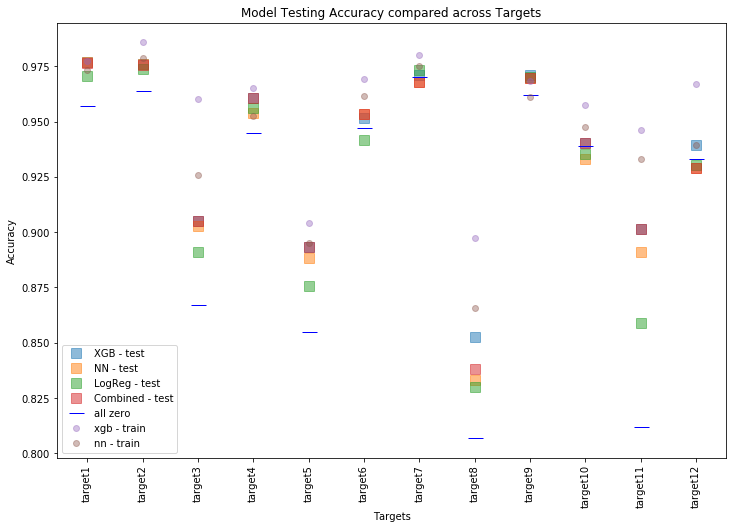

In [12]:
#ACCURACY PLOT
plt.figure(figsize=(12,8))
plt.plot(test_list, 's', alpha= 0.5, markersize = 10)
plt.plot([0.957,0.964,0.867,0.945,0.855,0.947,0.970,0.807,0.962,0.939,0.812,0.933], 'b_', markersize = 15 )

plt.plot(train_list, 'o', alpha = 0.4)
plt.legend(['XGB - test','NN - test','LogReg - test','Combined - test','all zero', 'xgb - train', 'nn - train'])

x = range(0,12);
target_ticks = []
for i in x:
    str1 = 'target'+str(i+1)
    target_ticks.append(str1)
plt.xticks(x,  target_ticks);
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
plt.xlabel("Targets")
plt.ylabel("Accuracy")
plt.title("Model Testing Accuracy compared across Targets")
plt.show()

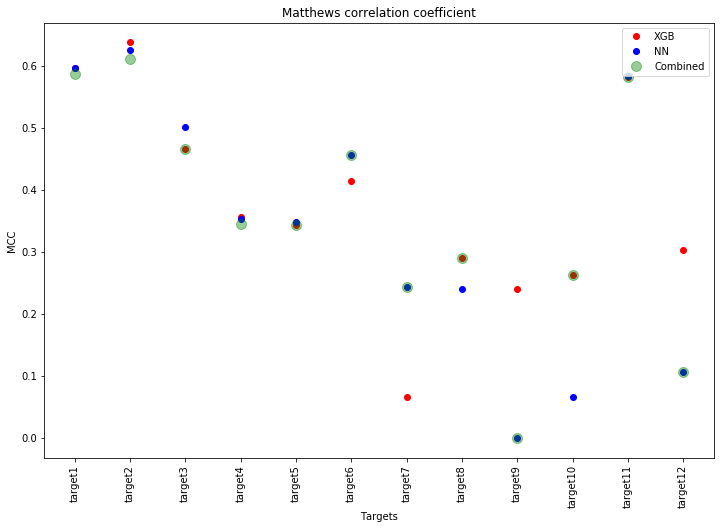

In [13]:
#MATTHEWS CORRELATION COEFFICIENT
plt.figure(figsize=(12,8))
plt.plot(xgb_mcc, 'ro', label = 'XGB')
plt.plot(nn_mcc, 'bo' , label = 'NN')
plt.plot(comb_mcc,'go', label = 'Combined', markersize = 10, alpha = 0.4)
plt.legend()
x = range(0,12);
target_ticks = []
for i in x:
    str1 = 'target'+str(i+1)
    target_ticks.append(str1)
plt.xticks(x,  target_ticks);
locs, labels = plt.xticks();
plt.setp(labels, rotation=90);
plt.xlabel("Targets")
plt.ylabel("MCC")
plt.title("Matthews correlation coefficient")
plt.show()